# UPSIT
University of Pennsylvania Smell Identification Test

In [16]:
import dask.dataframe as dd
import pandas as pd
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_curve
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
path=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Non-motor_Assessments/")
path2=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Archived_PPMI_Data")
path3=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Subject_Characteristics/")
path_data = Path("/home/znazari/data") # where the output data will be saved at the end.

In [3]:
upsit=pd.read_csv(path/"University_of_Pennsylvania_Smell_Identification_Test__UPSIT_.csv")

# Select rows where 'EVENT_ID' is 'BL'
upsit_bl = upsit[upsit['EVENT_ID'] == 'BL']
upsit["TOTAL_CORRECT"];

In [4]:
upsit2=pd.read_csv(path2/"University_of_Pennsylvania_Smell_ID_Test-Archived.csv")# larger dataset

upsit_bl = upsit2[upsit2["EVENT_ID"] == "BL"]
data_upsit = upsit_bl[["PATNO","UPSITBK1","UPSITBK2","UPSITBK3","UPSITBK4"]]
data_upsit

,PATNO,UPSITBK1,UPSITBK2,UPSITBK3,UPSITBK4
0,3000,9.0,10.0,6.0,10.0
2,3001,4.0,6.0,9.0,6.0
4,3002,3.0,5.0,3.0,6.0
6,3003,5.0,7.0,5.0,6.0
8,3004,10.0,10.0,8.0,8.0
...,...,...,...,...,...
2651,85236,5.0,3.0,4.0,3.0
2652,90456,5.0,5.0,4.0,5.0
2654,91097,5.0,4.0,5.0,4.0
2657,92490,3.0,1.0,3.0,3.0


In [5]:
diagnosis_=pd.read_csv(path3/"Participant_Status.csv")
diagnosis = diagnosis_[["PATNO","COHORT_DEFINITION"]]

In [6]:
filtered_diagnosis = diagnosis[diagnosis['COHORT_DEFINITION'].isin(['Healthy Control', "Parkinson's Disease"])]

In [7]:
merged_df_inner = pd.merge(data_upsit, filtered_diagnosis, on='PATNO', how='inner')

In [8]:
merged_df_inner.to_csv(path_data/'UPSIT.csv', index=False)

In [9]:
# Separate features (X) and target variable (y)
X = merged_df_inner.drop(['PATNO', 'COHORT_DEFINITION'], axis=1)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'COHORT' column
label = label_encoder.fit_transform(merged_df_inner['COHORT_DEFINITION'])

# Set the label for parkinson's disease and healthy control
merged_df_inner.loc[:, 'COHORT_DEFINITION'] = label

y = merged_df_inner['COHORT_DEFINITION']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

#  Initialize and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

#  Make predictions on the testing set
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)

# Print the AU-ROC score
print(f'AU-ROC Score: {au_roc_score}')

AU-ROC Score: 0.8209893048128343


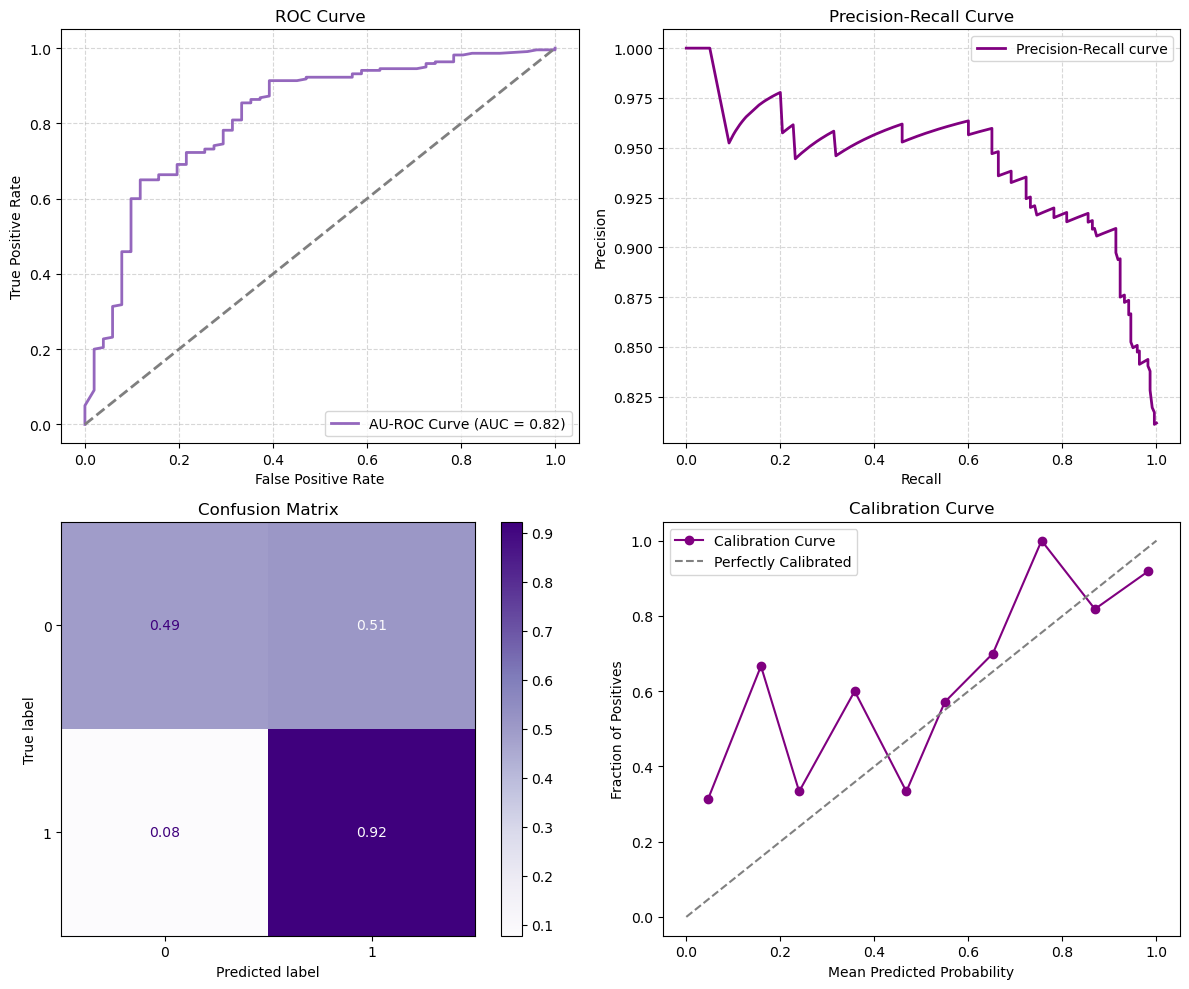

In [17]:
# Plotting all the figures in a 2x2 matrix
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axs[0, 0].plot(fpr, tpr, color='tab:purple', lw=2, label=f'AU-ROC Curve (AUC = {roc_auc:.2f})')
axs[0, 0].plot([0, 1], [0, 1], color='tab:grey', lw=2, linestyle='--')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].set_title('ROC Curve')
axs[0, 0].legend(loc='lower right')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axs[0, 1].plot(recall, precision, color='purple', lw=2, label='Precision-Recall curve')
axs[0, 1].set_xlabel('Recall')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].set_title('Precision-Recall Curve')
axs[0, 1].legend(loc='best')
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Plot Confusion Matrix
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Purples', values_format=".2f", ax=axs[1, 0])
axs[1, 0].set_title('Confusion Matrix')

# Plot Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
axs[1, 1].plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='purple', linestyle='-')
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
axs[1, 1].set_xlabel('Mean Predicted Probability')
axs[1, 1].set_ylabel('Fraction of Positives')
axs[1, 1].set_title('Calibration Curve')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
# Get the current date
current_date = datetime.now().date()

# Print the current date
print("Last update :", current_date)

Last update : 2024-03-01
